In [9]:
import os
import gc
import pickle
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.stats import spearmanr, pearsonr
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import squidpy as sq

#import spatialdm as sd

## Problem with duplicate cell names 

In [5]:
path = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/Liana+/rank_aggregate/Liana_RA_subsetTULB/anndata_subsetTULB/chuvio_L1_1_TULB.h5ad"

In [6]:
subTulb = sc.read_h5ad(path)

In [33]:
subTulb

AnnData object with n_obs × n_vars = 30208 × 313
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample_id', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'libsize_drop', 'sizeFactor', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'singler_annotation', 'ident'
    uns: 'X_name', 'design_matrix'
    obsm: 'PCA', 'TSNE', 'UMAP', 'design_matrix', 'spatial'
    layers: 'counts', 'logcounts'

In [36]:
subTulb.obs.index

Index(['L1_1_aaalgcgo-1', 'L1_1_aaaliehh-1', 'L1_1_aaalmapb-1',
       'L1_1_aaamjhkp-1', 'L1_1_aaamonim-1', 'L1_1_aaandagg-1',
       'L1_1_aaaognee-1', 'L1_1_aabalchc-1', 'L1_1_aabambhp-1',
       'L1_1_aabchjke-1',
       ...
       'L1_1_oibljphh-1', 'L1_1_oibolamo-1', 'L1_1_oicmofkg-1',
       'L1_1_oicokpba-1', 'L1_1_oidkpmma-1', 'L1_1_oidnjfic-1',
       'L1_1_oidnnoci-1', 'L1_1_oiedbogf-1', 'L1_1_oifafdfc-1',
       'L1_1_oifameeo-1'],
      dtype='object', length=30208)

In [40]:
# Get the index
index = subTulb.obs

# Find duplicates
duplicates = index[index.duplicated()]

# Print the number of duplicates
print(f"Number of duplicate indices: {len(duplicates)}")

# If there are duplicates, view them
if len(duplicates) > 0:
    print("\nDuplicate indices:")
    print(duplicates)

# Get a boolean mask of duplicate values (including first occurrences)
is_duplicate = index.duplicated(keep=False)

# Get the counts of each index value
index_counts = index.value_counts()

# Print indices that appear more than once
print("\nIndices appearing more than once:")
print(index_counts[index_counts > 1])

# Print total number of indices for reference
print(f"\nTotal number of indices: {len(index)}")

Number of duplicate indices: 0

Indices appearing more than once:
Series([], Name: count, dtype: int64)

Total number of indices: 30208


In [38]:
subTulb.obs

orig.ident  nCount_originalexp  nFeature_originalexp  \
L1_1_aaalgcgo-1         L1               271.0                    59   
L1_1_aaaliehh-1         L1               146.0                    57   
L1_1_aaalmapb-1         L1               207.0                    61   
L1_1_aaamjhkp-1         L1               212.0                    66   
L1_1_aaamonim-1         L1               286.0                    73   
...                    ...                 ...                   ...   
L1_1_oidnjfic-1         L1               396.0                    77   
L1_1_oidnnoci-1         L1                56.0                    38   
L1_1_oiedbogf-1         L1               163.0                    45   
L1_1_oifafdfc-1         L1               123.0                    54   
L1_1_oifameeo-1         L1               162.0                    57   

                         cell_id   x_centroid   y_centroid  transcript_counts  \
L1_1_aaalgcgo-1  L1_1_aaalgcgo-1  1225.276123  1704.640137                272   
L1_1_aaaliehh-1  L1_1_aaaliehh-1  1230.426392  1710.425781                147   
L1_1_aaalmapb-1  L1_1_aaalmapb-1  1229.844971  1693.043823                207   
L1_1_aaamjhkp-1  L1_1_aaamjhkp-1  1236.660522  1701.630737                212   
L1_1_aaamonim-1  L1_1_aaamonim-1  1237.511108  1691.806030                286   
...                          ...          ...          ...                ...   
L1_1_oidnjfic-1  L1_1_oidnjfic-1  2572.963623   890.420776                397   
L1_1_oidnnoci-1  L1_1_oidnnoci-1  2584.522949   912.250916                 56   
L1_1_oiedbogf-1  L1_1_oiedbogf-1  2599.338379   894.457031                163   
L1_1_oifafdfc-1  L1_1_oifafdfc-1  2634.781250   942.610168                123   
L1_1_oifameeo-1  L1_1_oifameeo-1  2635.834961   988.692505                164   

                 control_probe_counts  control_codeword_counts  \
L1_1_aaalgcgo-1                     1                        0   
L1_1_aaaliehh-1                     4                        1   
L1_1_aaalmapb-1                     2                        0   
L1_1_aaamjhkp-1                     0                        0   
L1_1_aaamonim-1                     1                        0   
...                               ...                      ...   
L1_1_oidnjfic-1                     2                        0   
L1_1_oidnnoci-1                     1                        0   
L1_1_oiedbogf-1                     0                        0   
L1_1_oifafdfc-1                     0                        0   
L1_1_oifameeo-1                     0                        0   

                 unassigned_codeword_counts  ...  subsets_Mito_percent  total  \
L1_1_aaalgcgo-1                           3  ...                   0.0  272.0   
L1_1_aaaliehh-1                           0  ...                   0.0  147.0   
L1_1_aaalmapb-1                           3  ...                   0.0  207.0   
L1_1_aaamjhkp-1                           1  ...                   0.0  212.0   
L1_1_aaamonim-1                           2  ...                   0.0  286.0   
...                                     ...  ...                   ...    ...   
L1_1_oidnjfic-1                           3  ...                   0.0  397.0   
L1_1_oidnnoci-1                           0  ...                   0.0   56.0   
L1_1_oiedbogf-1                           2  ...                   0.0  163.0   
L1_1_oifafdfc-1                           0  ...                   0.0  123.0   
L1_1_oifameeo-1                           0  ...                   0.0  164.0   

                 libsize_drop  sizeFactor nCount_SCT  nFeature_SCT  \
L1_1_aaalgcgo-1         False    1.650702      148.0            48   
L1_1_aaaliehh-1         False    0.889308      145.0            56   
L1_1_aaalmapb-1         False    1.260868      152.0            60   
L1_1_aaamjhkp-1         False    1.291324      155.0            66   
L1_1_aaamonim-1         False    1.742069      164.0          

In [34]:
subTulb.obs['cell_id']

L1_1_aaalgcgo-1    L1_1_aaalgcgo-1
L1_1_aaaliehh-1    L1_1_aaaliehh-1
L1_1_aaalmapb-1    L1_1_aaalmapb-1
L1_1_aaamjhkp-1    L1_1_aaamjhkp-1
L1_1_aaamonim-1    L1_1_aaamonim-1
                        ...       
L1_1_oidnjfic-1    L1_1_oidnjfic-1
L1_1_oidnnoci-1    L1_1_oidnnoci-1
L1_1_oiedbogf-1    L1_1_oiedbogf-1
L1_1_oifafdfc-1    L1_1_oifafdfc-1
L1_1_oifameeo-1    L1_1_oifameeo-1
Name: cell_id, Length: 30208, dtype: object

In [31]:
subTulb.obs.columns

Index(['orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_id',
       'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts',
       'control_codeword_counts', 'unassigned_codeword_counts',
       'deprecated_codeword_counts', 'total_counts', 'cell_area',
       'nucleus_area', 'sample_id', 'sum', 'detected', 'subsets_Mito_sum',
       'subsets_Mito_detected', 'subsets_Mito_percent', 'total',
       'libsize_drop', 'sizeFactor', 'nCount_SCT', 'nFeature_SCT',
       'SCT_snn_res.0.8', 'seurat_clusters', 'singler_annotation', 'ident'],
      dtype='object')

In [32]:
sub20g.obs.columns

Index(['orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_id',
       'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts',
       'control_codeword_counts', 'unassigned_codeword_counts',
       'deprecated_codeword_counts', 'total_counts', 'cell_area',
       'nucleus_area', 'sample_id', 'sum', 'detected', 'subsets_Mito_sum',
       'subsets_Mito_detected', 'subsets_Mito_percent', 'total',
       'libsize_drop', 'sizeFactor', 'nCount_SCT', 'nFeature_SCT',
       'SCT_snn_res.0.8', 'seurat_clusters', 'singler_annotation', 'ident',
       'RCTD_lvl3'],
      dtype='object')

### Comparing with other subsets that worked  

In [ ]:
Where 

In [17]:
path_20g = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/Programming/synthetic_data/sub20genes/chuvio_L1_1_20genes.h5ad"
sub20g = sc.read_h5ad(path_20g)

In [19]:
sub20g.obs

orig.ident  nCount_originalexp  nFeature_originalexp  \
L1_1_aaaadbga-1         L1               413.0                   103   
L1_1_aaaajnma-1         L1               253.0                    86   
L1_1_aaadecno-1         L1               176.0                    66   
L1_1_aaafkiae-1         L1               293.0                   111   
L1_1_aaahijio-1         L1               175.0                    73   
...                    ...                 ...                   ...   
L1_1_oielkile-1         L1               131.0                    54   
L1_1_oieofjmb-1         L1               144.0                    44   
L1_1_oieokhmm-1         L1               158.0                    69   
L1_1_oifafdfc-1         L1               123.0                    54   
L1_1_oifameeo-1         L1               162.0                    57   

                         cell_id   x_centroid   y_centroid  transcript_counts  \
L1_1_aaaadbga-1  L1_1_aaaadbga-1  1186.546265  1686.810181                413   
L1_1_aaaajnma-1  L1_1_aaaajnma-1  1194.922241  1699.988892                253   
L1_1_aaadecno-1  L1_1_aaadecno-1  1196.921997  1708.868652                176   
L1_1_aaafkiae-1  L1_1_aaafkiae-1  1204.801636  1698.712280                293   
L1_1_aaahijio-1  L1_1_aaahijio-1  1209.148804  1690.650635                175   
...                          ...          ...          ...                ...   
L1_1_oielkile-1  L1_1_oielkile-1  2610.254639   992.233582                131   
L1_1_oieofjmb-1  L1_1_oieofjmb-1  2618.554688   977.565002                145   
L1_1_oieokhmm-1  L1_1_oieokhmm-1  2618.840332   959.367188                158   
L1_1_oifafdfc-1  L1_1_oifafdfc-1  2634.781250   942.610168                123   
L1_1_oifameeo-1  L1_1_oifameeo-1  2635.834961   988.692505                164   

                 control_probe_counts  control_codeword_counts  \
L1_1_aaaadbga-1                     1                        0   
L1_1_aaaajnma-1                     1                        0   
L1_1_aaadecno-1                     0                        0   
L1_1_aaafkiae-1                     1                        0   
L1_1_aaahijio-1                     0                        0   
...                               ...                      ...   
L1_1_oielkile-1                     0                        0   
L1_1_oieofjmb-1                     0                        0   
L1_1_oieokhmm-1                     0                        0   
L1_1_oifafdfc-1                     0                        0   
L1_1_oifameeo-1                     0                        0   

                 unassigned_codeword_counts  ...  total  libsize_drop  \
L1_1_aaaadbga-1                           0  ...  413.0         False   
L1_1_aaaajnma-1                           0  ...  253.0         False   
L1_1_aaadecno-1                           0  ...  176.0         False   
L1_1_aaafkiae-1                           0  ...  293.0         False   
L1_1_aaahijio-1                           1  ...  175.0         False   
...                                     ...  ...    ...           ...   
L1_1_oielkile-1                           0  ...  131.0         False   
L1_1_oieofjmb-1                           0  ...  145.0         False   
L1_1_oieokhmm-1                           0  ...  158.0         False   
L1_1_oifafdfc-1                           0  ...  123.0         False   
L1_1_oifameeo-1                           0  ...  164.0         False   

                 sizeFactor  nCount_SCT nFeature_SCT  SCT_snn_res.0.8  \
L1_1_aaaadbga-1    2.515645       143.0           52                9   
L1_1_aaaajnma-1    1.541061       159.0           78                9   
L1_1_aaadecno-1    1.072042       157.0           66                9   
L1_1_aaafkiae-1    1.784707       155.0           88                6   
L1_1_aaahijio-1    1.065951       154.0           72                8   
...                     ...         ...          ...              ... 

Check the name of the columns with the first anndata object

In [21]:
sub20g.obs.columns

Index(['orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_id',
       'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts',
       'control_codeword_counts', 'unassigned_codeword_counts',
       'deprecated_codeword_counts', 'total_counts', 'cell_area',
       'nucleus_area', 'sample_id', 'sum', 'detected', 'subsets_Mito_sum',
       'subsets_Mito_detected', 'subsets_Mito_percent', 'total',
       'libsize_drop', 'sizeFactor', 'nCount_SCT', 'nFeature_SCT',
       'SCT_snn_res.0.8', 'seurat_clusters', 'singler_annotation', 'ident',
       'RCTD_lvl3'],
      dtype='object')

In [ ]:
Where are the 

In [22]:
subTulb.obs.columns

Index(['orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_id',
       'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts',
       'control_codeword_counts', 'unassigned_codeword_counts',
       'deprecated_codeword_counts', 'total_counts', 'cell_area',
       'nucleus_area', 'sample_id', 'sum', 'detected', 'subsets_Mito_sum',
       'subsets_Mito_detected', 'subsets_Mito_percent', 'total',
       'libsize_drop', 'sizeFactor', 'nCount_SCT', 'nFeature_SCT',
       'SCT_snn_res.0.8', 'seurat_clusters', 'singler_annotation', 'ident'],
      dtype='object')

In [25]:
# Get the column names for both datasets
subTulb_columns = set(subTulb.obs.columns)
sub20g_columns = set(sub20g.obs.columns)

# Find columns unique to subTulb
unique_to_subTulb = subTulb_columns - sub20g_columns

# Find columns unique to sub20g
unique_to_sub20g = sub20g_columns - subTulb_columns

# Find common columns
common_columns = subTulb_columns.intersection(sub20g_columns)

# Print the results
print("Columns unique to subTulb:")
print(sorted(unique_to_subTulb))
print(f"\nNumber of unique columns in subTulb: {len(unique_to_subTulb)}")

print("\nColumns unique to sub20g:")
print(sorted(unique_to_sub20g))
print(f"\nNumber of unique columns in sub20g: {len(unique_to_sub20g)}")

print("\nCommon columns:")
print(sorted(common_columns))
print(f"\nNumber of common columns: {len(common_columns)}")

# Print total number of columns in each dataset for reference
print(f"\nTotal columns in subTulb: {len(subTulb.obs.columns)}")
print(f"Total columns in sub20g: {len(sub20g.obs.columns)}")

Columns unique to subTulb:
[]

Number of unique columns in subTulb: 0

Columns unique to sub20g:
['RCTD_lvl3']

Number of unique columns in sub20g: 1

Common columns:
['SCT_snn_res.0.8', 'cell_area', 'cell_id', 'control_codeword_counts', 'control_probe_counts', 'deprecated_codeword_counts', 'detected', 'ident', 'libsize_drop', 'nCount_SCT', 'nCount_originalexp', 'nFeature_SCT', 'nFeature_originalexp', 'nucleus_area', 'orig.ident', 'sample_id', 'seurat_clusters', 'singler_annotation', 'sizeFactor', 'subsets_Mito_detected', 'subsets_Mito_percent', 'subsets_Mito_sum', 'sum', 'total', 'total_counts', 'transcript_counts', 'unassigned_codeword_counts', 'x_centroid', 'y_centroid']

Number of common columns: 29

Total columns in subTulb: 29
Total columns in sub20g: 30


## Check for the results of the synthetic datasets

In [9]:
# We also need to compare the original datasets, by importing the original dataset
h5ad_file = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium/xenium_objs/anndata/chuvio_L1_1.h5ad"
chuvio_l1_1 = sc.read_h5ad(h5ad_file)

In [18]:
chuvio_l1_1

AnnData object with n_obs × n_vars = 71187 × 313
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample_id', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'libsize_drop', 'sizeFactor', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'singler_annotation', 'ident'
    uns: 'X_name'
    obsm: 'PCA', 'TSNE', 'UMAP'
    layers: 'logcounts'

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


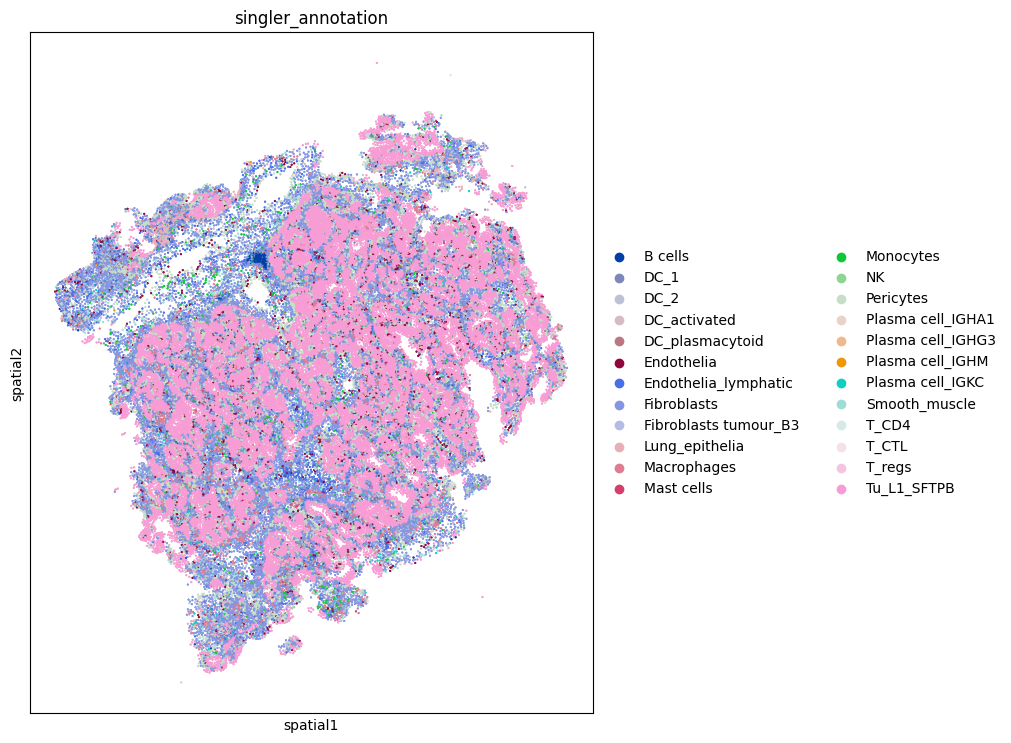

In [20]:
#testing the tissue plotting 
chuvio_l1_1.obsm['spatial'] = chuvio_l1_1.obs[['x_centroid', 'y_centroid']].to_numpy()
sq.pl.spatial_scatter(chuvio_l1_1, figsize = (10,10), color=['singler_annotation'], library_id = 'spatial', size=1, shape=None)

### a. TuLb subset

In [6]:
#Where do we get these from ? 
path = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/Programming/synthetic_data/subTulb/V1_simu_sce_subTulb.h5ad"
subTulb = sc.read_h5ad(path)

#### Plotting cell type

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


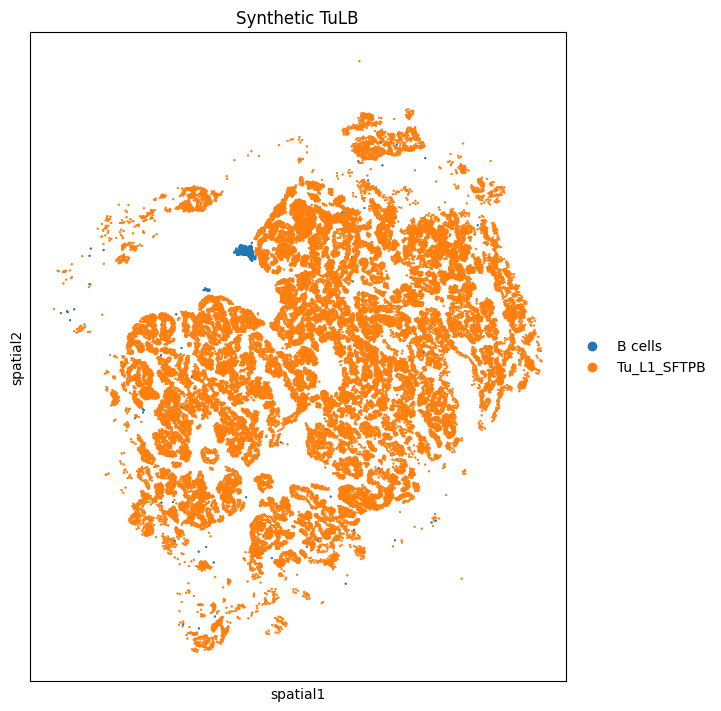

In [30]:
subTulb.obsm['spatial'] = subTulb.obs[['spatial1', 'spatial2']].to_numpy()
sq.pl.spatial_scatter(subTulb, figsize = (7,7), title = "Synthetic TuLB", color=['singler_annotation'], library_id = 'spatial', size=1, shape=None)

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


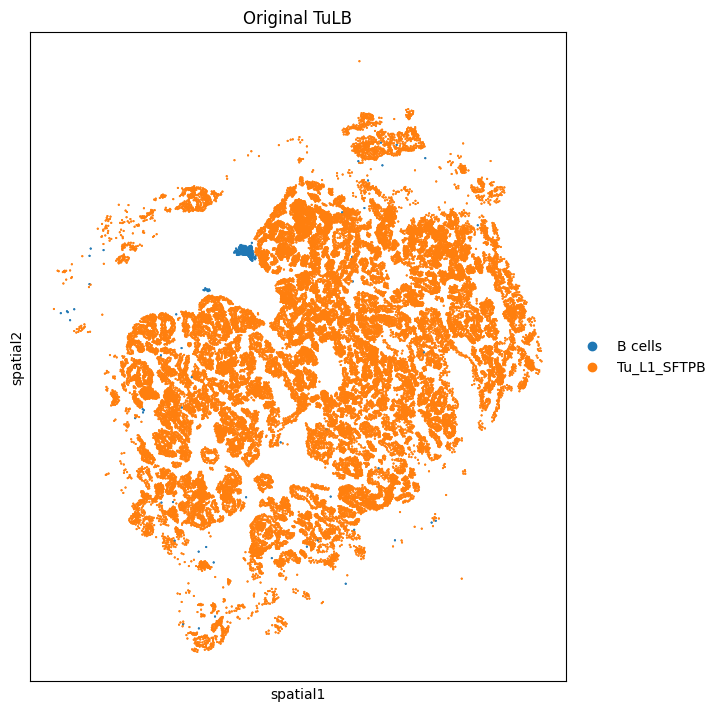

In [29]:
#Compare with the original tulb dataset : 
h5ad_file = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/Liana+/rank_aggregate/Liana_RA_subsetTULB/anndata_subsetTULB/chuvio_L1_1_TULB.h5ad"
OrigTulb = sc.read_h5ad(h5ad_file)
sq.pl.spatial_scatter(OrigTulb, figsize = (7,7), title = "Original TuLB", color=['singler_annotation'], library_id = 'spatial', size=1, shape=None)

#### Plotting EGFR gene expression

In [43]:
OrigTulb

AnnData object with n_obs × n_vars = 30208 × 313
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample_id', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'libsize_drop', 'sizeFactor', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'singler_annotation', 'ident'
    uns: 'X_name', 'design_matrix', 'singler_annotation_colors'
    obsm: 'PCA', 'TSNE', 'UMAP', 'design_matrix', 'spatial'
    layers: 'counts', 'logcounts'

In [ ]:
gene_list = OrigTulb.var_names.tolist()

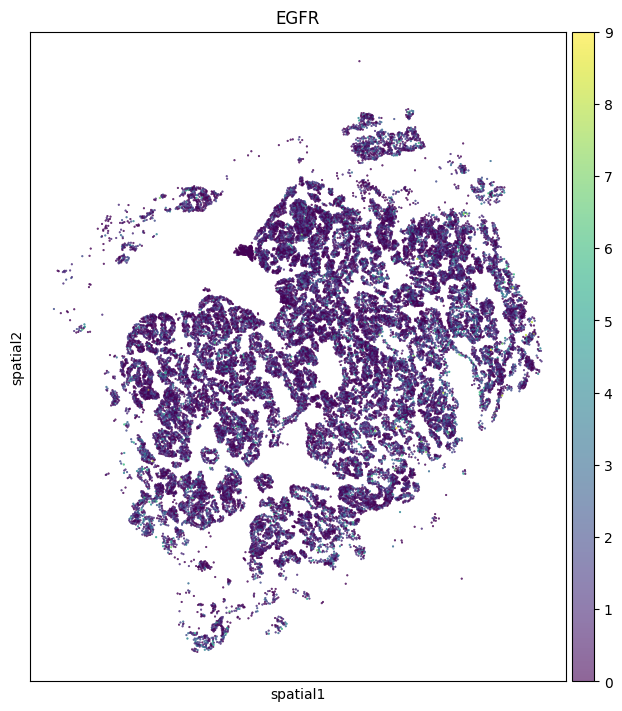

In [70]:
sq.pl.spatial_scatter(
    OrigTulb,
    library_id="spatial",
    color= ["EGFR"],
    figsize = (7,7),
    shape=None,
    alpha = 0.6,
    size=1,
    img=False,
)

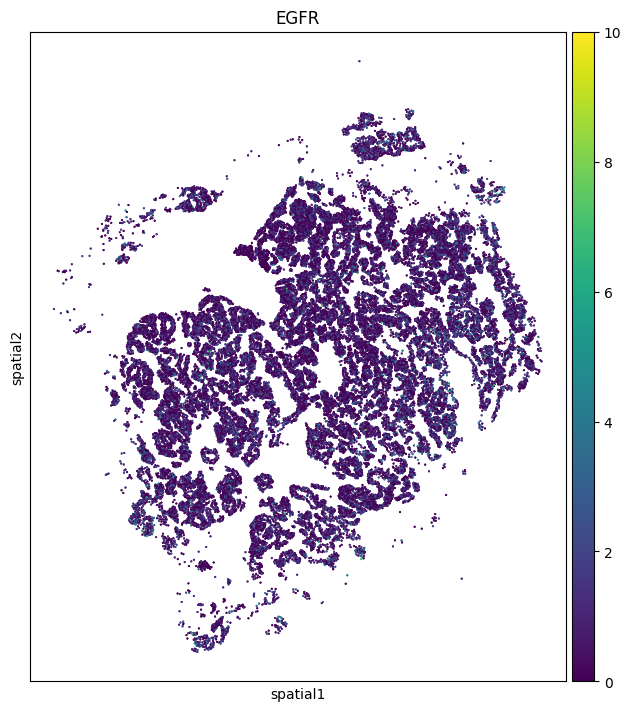

In [63]:
sq.pl.spatial_scatter(
    subTulb,
    library_id="spatial",
    color= ["EGFR"],
    figsize = (7,7),
    shape=None,
    size=1,
    img=False,
)

In [65]:
if 'EGFR' in OrigTulb.var_names:
    # Get the index of EGFR in the var_names
    egfr_index = OrigTulb.var_names.get_loc('EGFR')
    
    # Sum EGFR expression across all cells in the logcounts layer
    egfr_sum = OrigTulb.layers['logcounts'][:, egfr_index].sum()
    
    print(f"Sum of EGFR expression (logcounts) across all cells in orignal subset: {egfr_sum}")
else:
    print("EGFR gene not found in the dataset")

Sum of EGFR expression (logcounts) across all cells in orignal subset: 16694.325376098743


In [67]:
if 'EGFR' in subTulb.var_names:
    # Get the index of EGFR in the var_names
    egfr_index = subTulb.var_names.get_loc('EGFR')
    
    # Sum EGFR expression across all cells in the logcounts layer
    egfr_sum = subTulb.layers['logcounts'][:, egfr_index].sum()
    
    print(f"Sum of EGFR expression (logcounts) across all cells in synthetic subset: {egfr_sum}")
else:
    print("EGFR gene not found in the dataset")

Sum of EGFR expression (logcounts) across all cells in synthetic subset: 13601.511908449957


### b. 20k subset

#### plotting cell type

In [32]:
p_Original_20k = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/Programming/synthetic_data/sub20K/L1_1_sub20K.h5ad"
p_Synthetic_20k = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/Programming/synthetic_data/sub20K/V1_simu_sce_20K.h5ad"

Original_20k = sc.read_h5ad(p_Original_20k)
Synthetic_20k = sc.read_h5ad(p_Synthetic_20k)

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


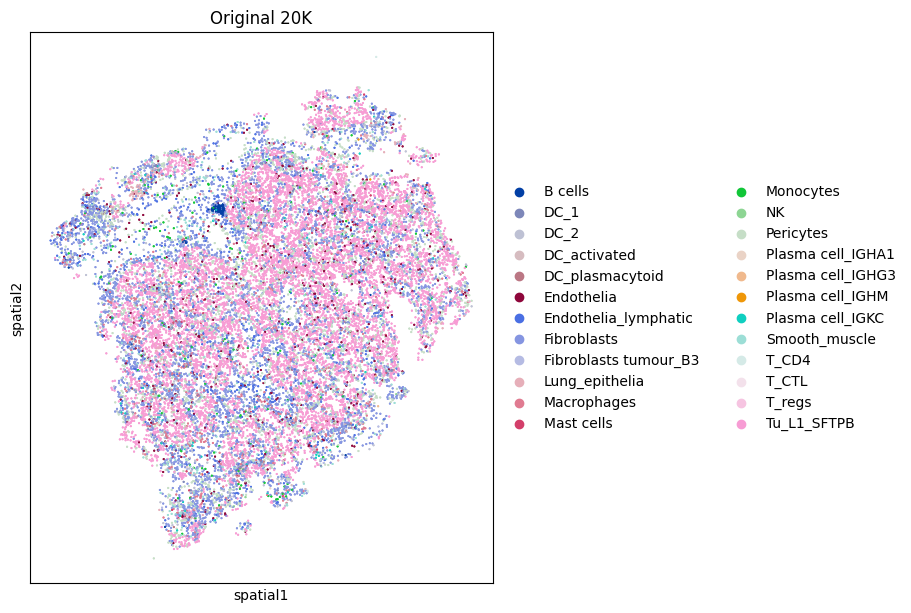

In [37]:
sq.pl.spatial_scatter(Original_20k, figsize = (9,9), title = "Original 20K", color=['singler_annotation'], library_id = 'spatial', size=1, shape=None)

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


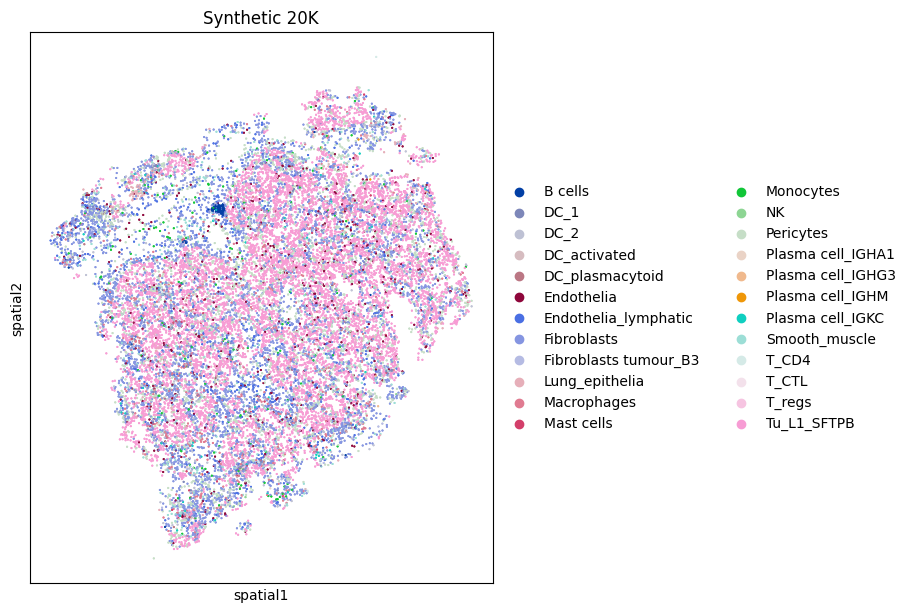

In [38]:
Synthetic_20k.obsm['spatial'] = Synthetic_20k.obs[['spatial1', 'spatial2']].to_numpy()
sq.pl.spatial_scatter(Synthetic_20k, figsize = (9,9), title = "Synthetic 20K", color=['singler_annotation'], library_id = 'spatial', size=1, shape=None)

#### plotting gene EGFR expression

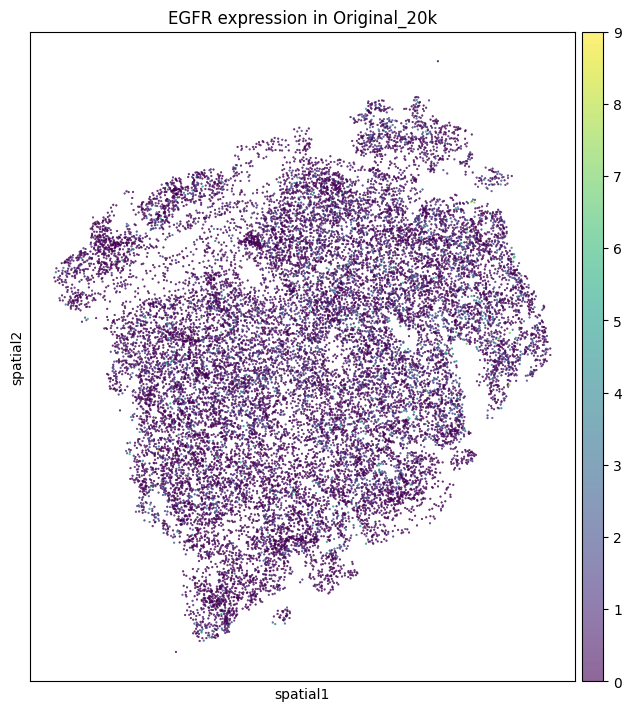

In [79]:
sq.pl.spatial_scatter(
    Original_20k,
    library_id="spatial",
    color= ["EGFR"],
    title = "EGFR expression in Original_20k",
    figsize = (7,7),
    shape=None,
    alpha = 0.6,
    size=1,
    img=False,
)

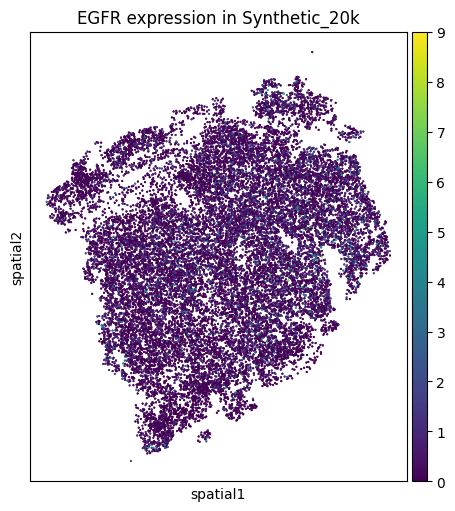

In [81]:
sq.pl.spatial_scatter(
    Synthetic_20k,
    library_id="spatial",
    color= ["EGFR"],
    figsize = (5,5),
    title = "EGFR expression in Synthetic_20k",
    shape=None,
    size=1,
    img=False,
)

In [76]:
file_name = "Synthetic_20k"
file = Synthetic_20k

if 'EGFR' in file.var_names:
    # Get the index of EGFR in the var_names
    egfr_index = file.var_names.get_loc('EGFR')
    
    # Sum EGFR expression across all cells in the logcounts layer
    egfr_sum = file.layers['logcounts'][:, egfr_index].sum()
    
    print(f"Sum of EGFR expression (logcounts) across all cells in {file_name}: {egfr_sum}")
else:
    print("EGFR gene not found in the dataset")

Sum of EGFR expression (logcounts) across all cells in Synthetic_20k: 4765.24843950627


In [75]:
file_name = "Original_20k"
file = Original_20k

if 'EGFR' in file.var_names:
    # Get the index of EGFR in the var_names
    egfr_index = file.var_names.get_loc('EGFR')
    
    # Sum EGFR expression across all cells in the logcounts layer
    egfr_sum = file.layers['logcounts'][:, egfr_index].sum()
    
    print(f"Sum of EGFR expression (logcounts) across all cells in {file_name}: {egfr_sum}")
else:
    print("EGFR gene not found in the dataset")

Sum of EGFR expression (logcounts) across all cells in Original_20k: 6177.361674331337


### c. 20genes subset

#### plotting cell type

In [20]:
p_Original_20g = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/Programming/synthetic_data/sub20genes/chuvio_L1_1_20genes.h5ad"
p_Synthetic_20g = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/Programming/synthetic_data/sub20genes/V1_simu_sce_20genes.h5ad"

Original_20g = sc.read_h5ad(p_Original_20g)
Synthetic_20g = sc.read_h5ad(p_Synthetic_20g)

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


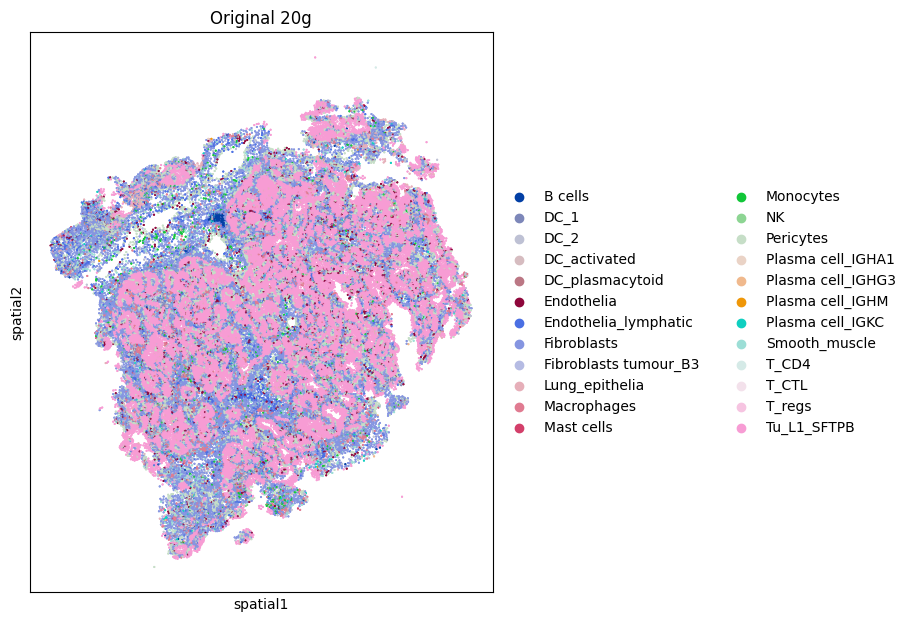

In [4]:
sq.pl.spatial_scatter(Original_20g, figsize = (9,9), title = "Original 20g", color=['singler_annotation'], library_id = 'spatial', size=1, shape=None)

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


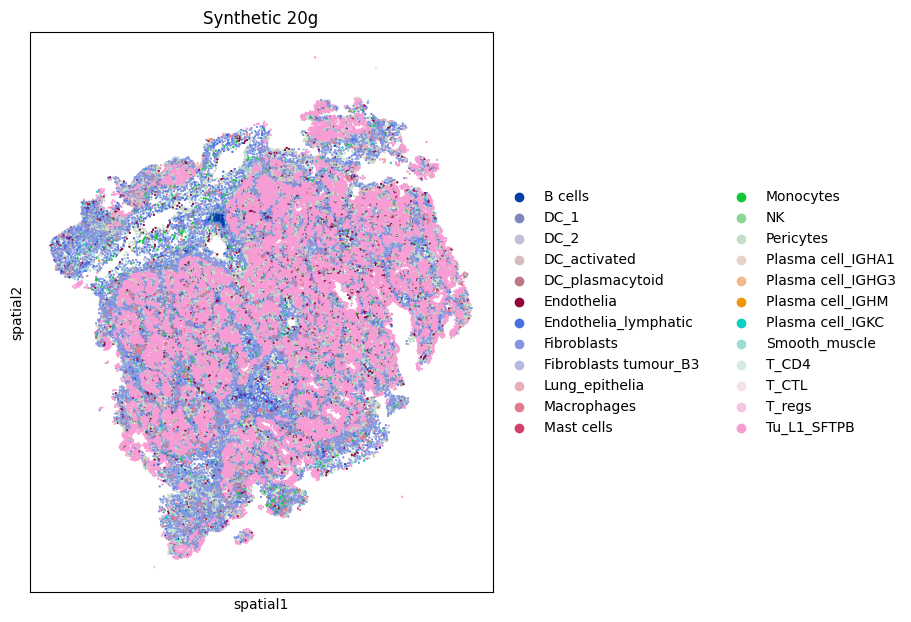

In [6]:
Synthetic_20g.obsm['spatial'] = Synthetic_20g.obs[['spatial1', 'spatial2']].to_numpy()
sq.pl.spatial_scatter(Synthetic_20g, figsize = (9,9), title = "Synthetic 20g", color=['singler_annotation'], library_id = 'spatial', size=1, shape=None)

#### plotting gene EGFR expression

KeyError: 'Could not find key gene_sum in .var_names or .obs.columns.'

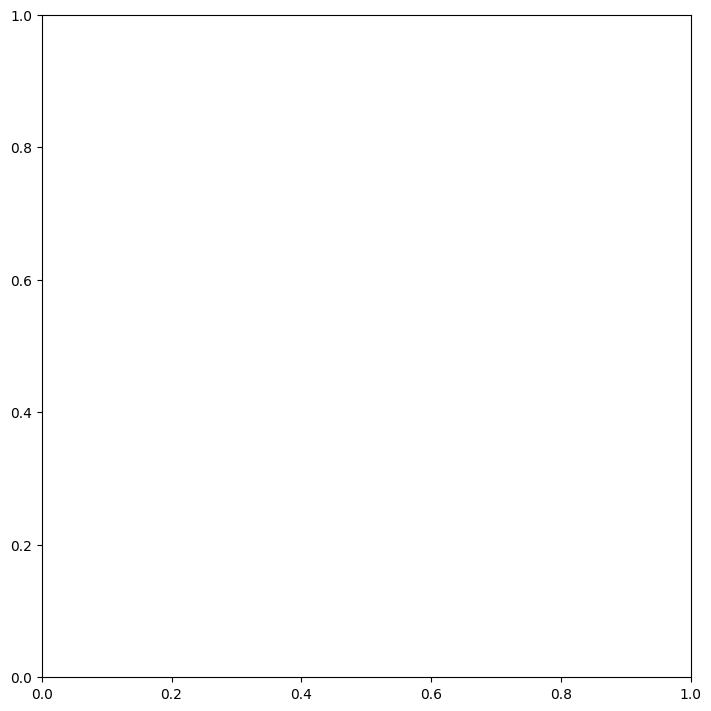

In [27]:
sq.pl.spatial_scatter(
    Original_20g,
    library_id="spatial",
    color= ["gene_sum"],
    title = "EGFR expression in Original_20g",
    figsize = (7,7),
    shape=None,
    alpha = 0.6,
    size=1,
    img=False,
)

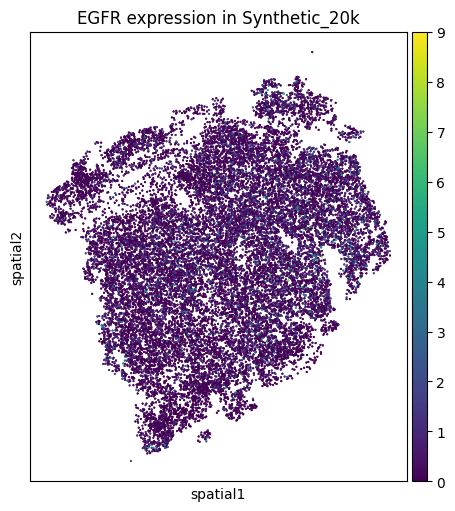

In [81]:
sq.pl.spatial_scatter(
    Synthetic_20k,
    library_id="spatial",
    color= ["EGFR"],
    figsize = (5,5),
    title = "EGFR expression in Synthetic_20k",
    shape=None,
    size=1,
    img=False,
)

In [76]:
file_name = "Synthetic_20k"
file = Synthetic_20k

if 'EGFR' in file.var_names:
    # Get the index of EGFR in the var_names
    egfr_index = file.var_names.get_loc('EGFR')
    
    # Sum EGFR expression across all cells in the logcounts layer
    egfr_sum = file.layers['logcounts'][:, egfr_index].sum()
    
    print(f"Sum of EGFR expression (logcounts) across all cells in {file_name}: {egfr_sum}")
else:
    print("EGFR gene not found in the dataset")

Sum of EGFR expression (logcounts) across all cells in Synthetic_20k: 4765.24843950627


In [75]:
file_name = "Original_20k"
file = Original_20k

if 'EGFR' in file.var_names:
    # Get the index of EGFR in the var_names
    egfr_index = file.var_names.get_loc('EGFR')
    
    # Sum EGFR expression across all cells in the logcounts layer
    egfr_sum = file.layers['logcounts'][:, egfr_index].sum()
    
    print(f"Sum of EGFR expression (logcounts) across all cells in {file_name}: {egfr_sum}")
else:
    print("EGFR gene not found in the dataset")

Sum of EGFR expression (logcounts) across all cells in Original_20k: 6177.361674331337


#### plotting total gene expression for the top 20 g tissues

In [21]:
Original_20g

AnnData object with n_obs × n_vars = 71187 × 25
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample_id', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'libsize_drop', 'sizeFactor', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'singler_annotation', 'ident', 'RCTD_lvl3'
    uns: 'X_name'
    obsm: 'PCA', 'TSNE', 'UMAP', 'spatial'
    layers: 'logcounts'

In [30]:
Original_20g

AnnData object with n_obs × n_vars = 71187 × 25
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample_id', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'libsize_drop', 'sizeFactor', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'singler_annotation', 'ident', 'RCTD_lvl3'
    var: 'gene_sum'
    uns: 'X_name'
    obsm: 'PCA', 'TSNE', 'UMAP', 'spatial'
    layers: 'logcounts'

In [29]:
Original_20g.var

gene_sum
BANK1     3429.0
CCL19     2117.0
CCL2     17583.0
CCL22     2569.0
CCL3      1773.0
CCL4      7434.0
CCL5     15973.0
CCR1      6181.0
CCR2      4780.0
CCR4      3251.0
CCR5      5370.0
CCR7       884.0
CXCR3     1587.0
DES      10463.0
EGF       7942.0
EGFR     29901.0
ERBB2   126132.0
EREG      1081.0
HGF      22946.0
IL32      3117.0
LUM     207672.0
RNASE1   41948.0
STAT4     6329.0
TRDV2      685.0
XCL1      1490.0

In [28]:
gene_sums = np.array(Original_20g.X.sum(axis=0)).flatten()

# Add the sums as a new column to adata.var
Original_20g.var['gene_sum'] = gene_sumsadata.obs['gene_sum'] = np.array(adata.X.sum(axis=1)).flatten()

ValueError: Length of values (71187) does not match length of index (25)

In [19]:
Original_20g.var

gene_sum
BANK1     3429.0
CCL19     2117.0
CCL2     17583.0
CCL22     2569.0
CCL3      1773.0
CCL4      7434.0
CCL5     15973.0
CCR1      6181.0
CCR2      4780.0
CCR4      3251.0
CCR5      5370.0
CCR7       884.0
CXCR3     1587.0
DES      10463.0
EGF       7942.0
EGFR     29901.0
ERBB2   126132.0
EREG      1081.0
HGF      22946.0
IL32      3117.0
LUM     207672.0
RNASE1   41948.0
STAT4     6329.0
TRDV2      685.0
XCL1      1490.0

In [18]:
#Get the sum of genes... 

#create a new column that sums all the gene expression for each cell. 

Original_20g.var_names

Index(['BANK1', 'CCL19', 'CCL2', 'CCL22', 'CCL3', 'CCL4', 'CCL5', 'CCR1',
       'CCR2', 'CCR4', 'CCR5', 'CCR7', 'CXCR3', 'DES', 'EGF', 'EGFR', 'ERBB2',
       'EREG', 'HGF', 'IL32', 'LUM', 'RNASE1', 'STAT4', 'TRDV2', 'XCL1'],
      dtype='object')

## Checking the gene distribution in cells of synthetic sets

### Getting the datasets

In [10]:
p_Original_20k = "/Users/alecstear/Documents/ST_data/data/synthetic_data/sub20K/L1_1_sub20K.h5ad"
p_Synthetic_20k = "/Users/alecstear/Documents/ST_data/data/synthetic_data/sub20K/V1_simu_sce_20K.h5ad"

Original_20k = sc.read_h5ad(p_Original_20k)
Synthetic_20k = sc.read_h5ad(p_Synthetic_20k)

In [12]:
p_Original_25g = "/Users/alecstear/Documents/ST_data/data/synthetic_data/sub25genes/chuvio_L1_1_20genes.h5ad"
p_Synthetic_25g = "/Users/alecstear/Documents/ST_data/data/synthetic_data/sub25genes/V1_simu_sce_20genes.h5ad"

Original_25g = sc.read_h5ad(p_Original_25g)
Synthetic_25g = sc.read_h5ad(p_Synthetic_25g)

### Plotting the gene distribtions

In [14]:
Original_20k

AnnData object with n_obs × n_vars = 20000 × 313
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample_id', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'libsize_drop', 'sizeFactor', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'singler_annotation', 'ident', 'RCTD_lvl3'
    uns: 'X_name'
    obsm: 'PCA', 'TSNE', 'UMAP', 'spatial'
    layers: 'logcounts'

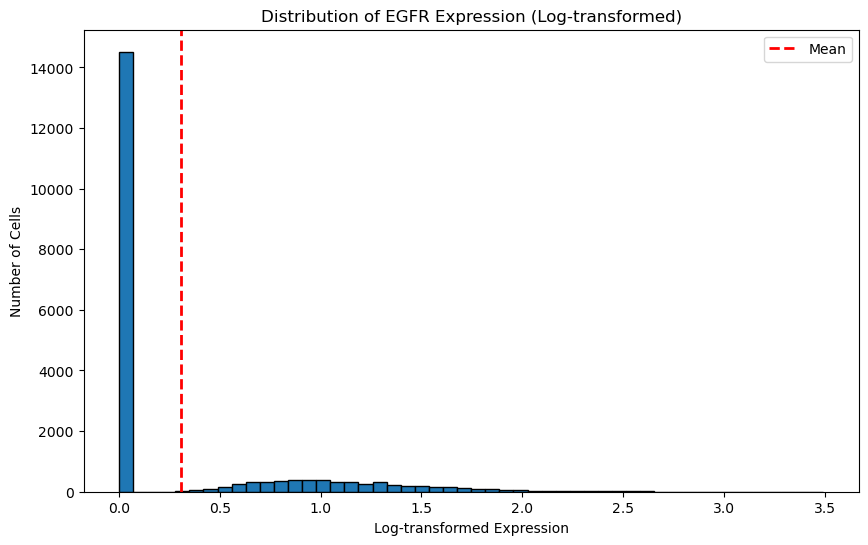

In [17]:
import scipy.sparse as sp


egfr_index = Original_20k.var_names.get_loc('EGFR')

# Extract the log-transformed expression values for EGFR
egfr_expression = Original_20k.layers['logcounts'][:, egfr_index]

# Convert sparse matrix to dense array
if sp.issparse(egfr_expression):
    egfr_expression = egfr_expression.toarray().flatten()
else:
    egfr_expression = egfr_expression.flatten()

# Create the plot
plt.figure(figsize=(10, 6))
plt.hist(egfr_expression, bins=50, edgecolor='black')
plt.title('Distribution of EGFR Expression (Log-transformed)')
plt.xlabel('Log-transformed Expression')
plt.ylabel('Number of Cells')
plt.axvline(np.mean(egfr_expression), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.legend()
plt.show()

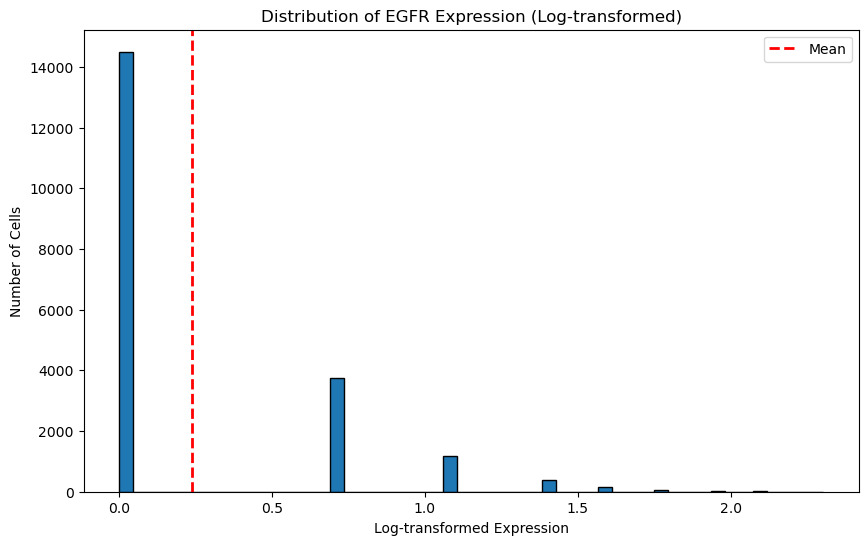

In [21]:
egfr_index = Synthetic_20k.var_names.get_loc('EGFR')

# Extract the log-transformed expression values for EGFR
egfr_expression = Synthetic_20k.layers['logcounts'][:, egfr_index]

# Convert sparse matrix to dense array
if sp.issparse(egfr_expression):
    egfr_expression = egfr_expression.toarray().flatten()
else:
    egfr_expression = egfr_expression.flatten()

# Create the plot
plt.figure(figsize=(10, 6))
plt.hist(egfr_expression, bins=50, edgecolor='black')
plt.title('Distribution of EGFR Expression (Log-transformed)')
plt.xlabel('Log-transformed Expression')
plt.ylabel('Number of Cells')
plt.axvline(np.mean(egfr_expression), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.legend()
plt.show()

In [22]:
egfr_index

101

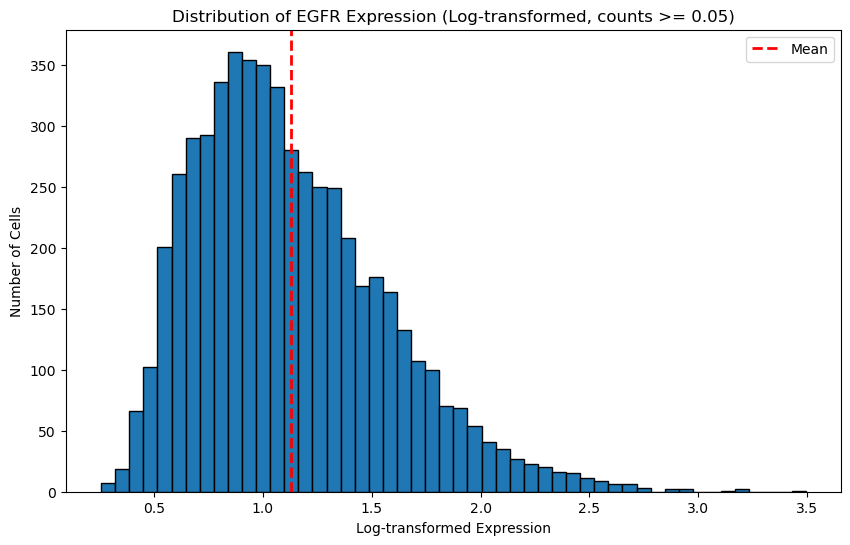

Total cells: 20000
Cells with expression >= 0.05: 5483
Percentage of cells with expression >= 0.05: 27.41%


In [18]:

# Assuming 'Original_20k' is your AnnData object
adata = Original_20k

# Get the index of the EGFR gene
egfr_index = adata.var_names.get_loc('EGFR')

# Extract the log-transformed expression values for EGFR
egfr_expression = adata.layers['logcounts'][:, egfr_index]

# Convert sparse matrix to dense array
if sp.issparse(egfr_expression):
    egfr_expression = egfr_expression.toarray().flatten()
else:
    egfr_expression = egfr_expression.flatten()

# Filter out counts less than 0.05
egfr_expression_filtered = egfr_expression[egfr_expression >= 0.05]

# Create the plot
plt.figure(figsize=(10, 6))
plt.hist(egfr_expression_filtered, bins=50, edgecolor='black')
plt.title('Distribution of EGFR Expression (Log-transformed, counts >= 0.05)')
plt.xlabel('Log-transformed Expression')
plt.ylabel('Number of Cells')
plt.axvline(np.mean(egfr_expression_filtered), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.legend()
plt.show()

# Print some statistics
print(f"Total cells: {len(egfr_expression)}")
print(f"Cells with expression >= 0.05: {len(egfr_expression_filtered)}")
print(f"Percentage of cells with expression >= 0.05: {len(egfr_expression_filtered) / len(egfr_expression) * 100:.2f}%")

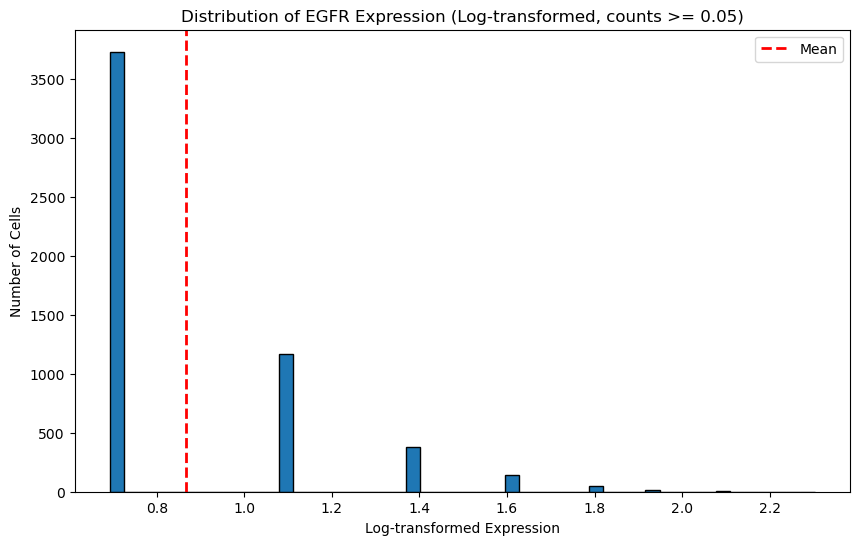

Total cells: 20000
Cells with expression >= 0.05: 5497
Percentage of cells with expression >= 0.05: 27.48%


In [19]:

# Assuming 'Original_20k' is your AnnData object
adata = Synthetic_20k

# Get the index of the EGFR gene
egfr_index = adata.var_names.get_loc('EGFR')

# Extract the log-transformed expression values for EGFR
egfr_expression = adata.layers['logcounts'][:, egfr_index]

# Convert sparse matrix to dense array
if sp.issparse(egfr_expression):
    egfr_expression = egfr_expression.toarray().flatten()
else:
    egfr_expression = egfr_expression.flatten()

# Filter out counts less than 0.05
egfr_expression_filtered = egfr_expression[egfr_expression >= 0.05]

# Create the plot
plt.figure(figsize=(10, 6))
plt.hist(egfr_expression_filtered, bins=50, edgecolor='black')
plt.title('Distribution of EGFR Expression (Log-transformed, counts >= 0.05)')
plt.xlabel('Log-transformed Expression')
plt.ylabel('Number of Cells')
plt.axvline(np.mean(egfr_expression_filtered), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.legend()
plt.show()

# Print some statistics
print(f"Total cells: {len(egfr_expression)}")
print(f"Cells with expression >= 0.05: {len(egfr_expression_filtered)}")
print(f"Percentage of cells with expression >= 0.05: {len(egfr_expression_filtered) / len(egfr_expression) * 100:.2f}%")

### Total gene expression for 20k 

In [3]:
adata = Original_20k

# Get the log-transformed expression values for all genes
all_gene_expression = adata.layers['logcounts']

# Convert sparse matrix to dense array
if sp.issparse(all_gene_expression):
    all_gene_expression = all_gene_expression.toarray()

# Calculate the sum of expression for all genes
gene_sums = all_gene_expression.sum(axis=0)

# Filter out genes with sum less than 0.05
gene_sums_filtered = gene_sums[gene_sums >= 0.05]

NameError: name 'Synthetic_20k' is not defined

### Total gene expression for 25g

In [13]:
Original_25g

AnnData object with n_obs × n_vars = 71187 × 25
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample_id', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'libsize_drop', 'sizeFactor', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'singler_annotation', 'ident', 'RCTD_lvl3'
    uns: 'X_name'
    obsm: 'PCA', 'TSNE', 'UMAP', 'spatial'
    layers: 'logcounts'